# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
# This magic code below is used to avoid the need to reimport files if they are edited externally.
%load_ext autoreload
%autoreload 2

# Show plots on notebook
%matplotlib inline

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
from models import ddpg, run_single_episode, DDPGAgent, plot_result, OUNoise
from models.parameters import device, check_device

In [11]:
# Checkig if a GPU is avalilable
check_device()

Using device: cuda:0


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [3]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### Examine the State and Action Spaces

The Tennis environment are configured as described below:

- Set-up: Two-player game where agents control rackets to bounce ball over a net.
- Goal: The agents must bounce ball between one another while not dropping or sending ball out of bounds.
- Agents: The environment contains **two agent** with same Behavior Parameters.
- Agent Reward Function (independent):
  - **+0.1** To agent when hitting ball over net.
  - **-0.1** To agent who let ball hit their ground, or hit ball out of bounds.
- Behavior Parameters:
  - Vector Observation space: **8 variables** corresponding to position and velocity of ball and racket.
  - Vector Action space: **(Continuous) Size of 2**, corresponding to movement toward net or away from net, and jumping.
- Benchmark Mean Reward: **2.5**

Source: https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#tennis


Run the code cell below to print some information about the selected environment.

In [15]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print(f'Number of agents: {num_agents}')

# size of each action
action_size = brain.vector_action_space_size
print(f'\nSize of each action: {action_size}')

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print(f'\nThere are {states.shape[0]} agents. Each observes a state with length: {state_size}')
print(f'\nThe state for the first agent looks like: \n{states[0]}')

Number of agents: 2

Size of each action: 2

There are 2 agents. Each observes a state with length: 24

The state for the first agent looks like: 
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.5099144  -1.5
 -0.          0.         -6.65305614  5.85873604 -0.          0.        ]


### Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

In [16]:
for i in range(1, 6): 
    scores = run_single_episode(env, brain_name, train_mode=False)

    print(f'Score (max over agents) from episode {i}: {np.max(scores):.3f} \t Each agent scores: {scores}')

Score (max over agents) from episode 1: 0.000 	 Each agent scores: [-0.01  0.  ]
Score (max over agents) from episode 2: 0.000 	 Each agent scores: [-0.01  0.  ]
Score (max over agents) from episode 3: 0.100 	 Each agent scores: [ 0.1  -0.01]
Score (max over agents) from episode 4: 0.000 	 Each agent scores: [ 0.   -0.01]
Score (max over agents) from episode 5: 0.000 	 Each agent scores: [ 0.   -0.01]


### Training the agent

Let's start training an agent in this environment.

The environment is considered solved, when the average (over 100 episodes and of all agents) scores is at least **+0.5**. 

The function `ddpg` from `model` package is the function that will train the Deep Deterministic Policy Gradient (DDPG) model from each episode until it achieves an moving average of 0.5 in scores for a windows of 100 episodes.

> The Deep Deterministic Policy Gradient (DDPG) is an Actor-Critic model architecture that approximate a DQN network (actor network), but can be used for continuous action space (like the Tennis problem). The critic network helps to reduce the variance while keeps the bias to a minimum value.

The chosen architecture uses an experience replay to breaks harmful correlations between episodes and to repeat rare episodes.

- Chosen parameters:

```python
BUFFER_SIZE = int(1e5)      # replay buffer size
BATCH_SIZE = 128            # minibatch size
GAMMA = 0.99                # discount factor
TAU = 2e-3                  # for soft update of target parameters
LR_ACTOR = 5e-4             # learning rate of the actor
LR_CRITIC = 2e-4            # learning rate of the critic
WEIGHT_DECAY = 0            # L2 weight decay

LEARN_STEPS = 1             # Lear evey N steps
N_UPDATES = 1               # Number of updates that will be realize in learn step
```

After some attempts, the learning rate for critic and actor was tunning to `5e-4` and `2e-4`. During the training, I faced problems like slow learning and fast learning but followed by forgetting (decreasing the score).

The learning steps (`LEARN_STEPS`) and the number of updates (`N_UPDATES`) parameters were reduced to only 1 because, in the first episodes, the number of steps in each episode was really small (most of the cases just one step).

The `TAU` parameter (used to inform how much the target network will be updated) was increased as a try to speed up the training.

- Noise

A noise (Ornstein-Uhlenbeck process) was added to the action output (actor network) to allow the training to explore more possibilities and avoid stay stuck at some point.

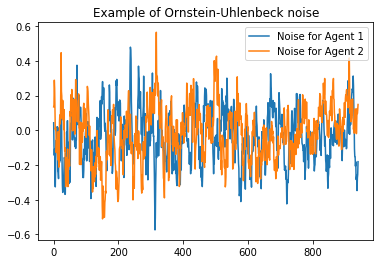

In [26]:
# Ornstein-Uhlenbeck noise plot for both agenst
noise = OUNoise(action_size, scale=1.0, sigma=.1)
plt.plot([noise.noise() * 0.9995**i for i in range(941)])
plt.legend(['Noise for Agent 1', 'Noise for Agent 2']);
plt.title('Example of Ornstein-Uhlenbeck noise');

In [8]:
# Let's start training the agent
scores, agent = ddpg(env)

- Actor Summary (both local and target): 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 400]          10,000
       BatchNorm1d-2                  [-1, 400]             800
            Linear-3                  [-1, 300]         120,300
            Linear-4                    [-1, 2]             602
Total params: 131,702
Trainable params: 131,702
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.50
Estimated Total Size (MB): 0.51
----------------------------------------------------------------
- Critic Summary (both local and target): 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 400]          10,000
       BatchNorm1d-2

Episode 100	Average Score: 0.00200	Last Episode Score: 0.00000	Saved!
Episode 200	Average Score: 0.01250	Last Episode Score: 0.10000	Saved!
Episode 300	Average Score: 0.03270	Last Episode Score: 0.00000	Saved!
Episode 400	Average Score: 0.01550	Last Episode Score: 0.10000	Saved!
Episode 500	Average Score: 0.05570	Last Episode Score: 0.00000	Saved!
Episode 600	Average Score: 0.08730	Last Episode Score: 0.10000	Saved!
Episode 700	Average Score: 0.13090	Last Episode Score: 0.10000	Saved!
Episode 800	Average Score: 0.31270	Last Episode Score: 0.30000	Saved!
Episode 900	Average Score: 0.31190	Last Episode Score: 0.20000	Saved!
Episode 941	Average Score: 0.50190	Last Episode Score: 1.40000	Saved!


In episode **941** (and after 30:01 minutes training in a local machine using GPU) the training was interrupted because the problem was solved.

In [11]:
# Saving the results scores
np.savetxt("results/scores.csv", scores, delimiter=",")

### Loading the traine episodes scores

After training the agent, let's load the scores to see the performance of the agent during the training.

In [14]:
# Load the result scores
scores = np.loadtxt("results/scores.csv", delimiter=",")

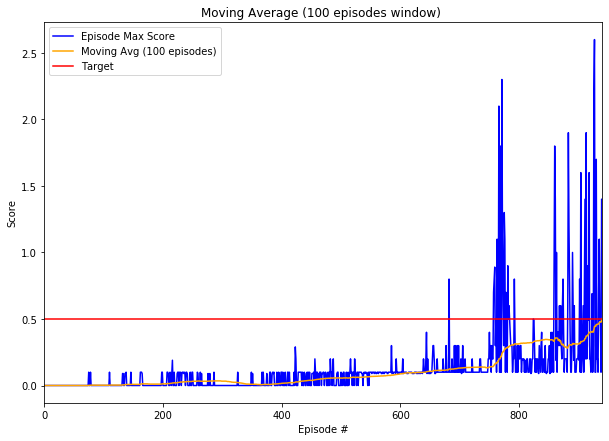

In [35]:
# Plot the result
plot_result(scores)

###  Testing the trained model

Let's load the saved agent and run a single episode to see how trained model behaves.

In [27]:
# Load the saved trained agent
agent = DDPGAgent.load(env)

In [31]:
single_episode_scores = run_single_episode(env, brain_name, agent, train_mode=False)

print(f'Total score (max over agents) this episode: {np.max(single_episode_scores):.3f} \t Each agent scores: {single_episode_scores}')

Total score (max over agents) this episode: 2.600 	 Each agent scores: [2.60000004 2.60000004]


### Interesting observation

For those who a familiar with tennis, most of the strokes executed by the agent were *slices*. If the agent were a robot and it was playing against a human, would be difficult to play because the *slice* is one of the most difficult strokes to counter because of the effect that the ball gain.

<img src="https://www.wikihow.com/images/thumb/6/62/Slice-Backhand-in-Tennis-Step-4.jpg/aid328357-v4-728px-Slice-Backhand-in-Tennis-Step-4.jpg" width="400"> 
Image source: https://www.wikihow.com/Slice-Backhand-in-Tennis

But I'm just thinking aloud, the environment didn't consider this because it would probably need to consider some factors like the friction of the air in the ball surface to make some effects.

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSC9pPdc11HlzZwtbmiHOUX_jtkQFEaRDdKcuIZ8mA56cauhMwNUA&s" width="400"> 
Image source: http://ffden-2.phys.uaf.edu/webproj/211_fall_2014/Max_Hesser-Knoll/max_hesserknoll/Slide3.htm

### Closing the Environment

When finished, you can close the environment.

In [32]:
env.close()

### Ideas for Future Work

In the future, a Prioritized Experience Replay can be used to improve the performance and decrease the variation per episode.

Another tentative to improve the result is to try to use the Proximal Policy Optimization (PPO) that, according to *OpenAI*, obtained a really good performance on some of their projects. https://openai.com/blog/openai-baselines-ppo/